In [77]:
TEST_MATRIX_SIZE = 5
ITERATIONS = 20
import numpy as np


# Generate a small test set
Test_Adjacency_Matrix = np.random.randint(10, size=(TEST_MATRIX_SIZE,TEST_MATRIX_SIZE))
Test_Adjacency_Matrix = np.add(Test_Adjacency_Matrix, np.ones(TEST_MATRIX_SIZE, dtype=int))

for i in range(len(Test_Adjacency_Matrix[0])):
    for j in range(i , len(Test_Adjacency_Matrix[1])):
        if i==j:
            Test_Adjacency_Matrix[i][j] = 0
        else:
            Test_Adjacency_Matrix[i,j] = Test_Adjacency_Matrix[j,i]

print(Test_Adjacency_Matrix)

Target_Data = Test_Adjacency_Matrix

[[0 7 3 7 4]
 [7 0 8 2 3]
 [3 8 0 8 5]
 [7 2 8 0 7]
 [4 3 5 7 0]]


##### Some settings

In [78]:
initial_schedule = list(range(len(Target_Data)))

##### Some methods

In [79]:
def Get_Schedule_Length(given_schedule):
    # Adjust the given_schedule (schedule), for example [A, B, C] -> [A, B, C, A]
    # then compute the travel distance of the given array.
    given_schedule = np.append(given_schedule, given_schedule[0])
    sum = 0
    for j in range(len(given_schedule)-1):
        sum += Target_Data[given_schedule[j],given_schedule[j+1]]
    return sum

##### 3(a) Hill Climbing

In [80]:
best_schedule = initial_schedule
best_result = Get_Schedule_Length(initial_schedule)

HC = [best_result]

# Start Iterations
for i in range(ITERATIONS):
    for j in range(1000): # try 10000 possible route in each iteration. (much less than 15!)
        current_schedule = np.random.permutation(best_schedule)
        if Get_Schedule_Length(current_schedule)<best_result:
            best_schedule = current_schedule
            best_result = Get_Schedule_Length(current_schedule)
    HC.append(best_result)
# print(HC)
HC_best_schedule = best_schedule

##### 3(b) Random Walk

In [81]:
best_result = Get_Schedule_Length(initial_schedule)
best_schedule = initial_schedule
RW = []
RW.append(best_result)

for i in range(ITERATIONS):
    # random select an route from the permutation of old schedule
    current_schedule = np.random.permutation(best_schedule)
    if Get_Schedule_Length(current_schedule)<best_result:
        best_schedule = current_schedule
        best_result = Get_Schedule_Length(current_schedule)
    RW.append(best_result)

RW_best_schedule = best_schedule

##### 3(c) Genetic Algorithm

In [82]:
POPULATION_SIZE = 10
CROSSOVER_PROBABILITY = 0.1
NUMBER_OF_PAIRS_OF_MULTI_BIT_FLIP = 2

def Generate_Population(initial_schedule):
    Population = []
    for i in range(POPULATION_SIZE):
        Single_Creature = np.random.permutation(initial_schedule)
        Population.append(Single_Creature)
    return Population

def Roulete_Wheel_Selection(Given_Matrix):
    A = []
    max = -np.inf
    for i in range(len(Given_Matrix)):
        schedule_length = Get_Schedule_Length(Given_Matrix[i])
        A.append(schedule_length)
        if schedule_length > max:
            max = schedule_length

    sum = 0
    for j in range(len(Given_Matrix)):
        sum += A[j]
        A[j] = sum

    Matepool = []
    for k in range(int(len(Given_Matrix)/2)):
        a = np.random.randint(sum)
        i=0
        while(a>A[i]):
            i += 1
        Matepool.append(Given_Matrix[i])

    return Matepool

def Uniform_Crossover(Given_Matrix):
    Test_Matrix = Given_Matrix
    for i in range(int(len(Test_Matrix)/2)):

        for j in range(int(len(Test_Matrix[i]))):
            a = np.random.uniform(0,1,1)
            if a >= CROSSOVER_PROBABILITY:
                # SWAP the elements among two weapons lists.
                Test_Matrix[2*i][j], Test_Matrix[2*i+1][j] = Test_Matrix[2*i+1][j], Test_Matrix[2*i][j]
    return Test_Matrix

def Multi_Bit_Flip_Mutation(Given_Matrix, Number_of_Pairs_of_Multi_Bit_Flip):
    Test_Matrix = Given_Matrix
    # Doubling the population size in the step\
    # \to make the amount of creatures fixed in each generations.
    Test_Matrix = np.concatenate((Test_Matrix, Test_Matrix))

    #
    for i in range(int(len(Test_Matrix)/2)):
        for j in range(Number_of_Pairs_of_Multi_Bit_Flip):
            interchange_location = np.random.randint(int(len(Test_Matrix[i])),size=2)
            Test_Matrix[i][interchange_location[0]], Test_Matrix[i][interchange_location[1]] =\
            Test_Matrix[i][interchange_location[1]], Test_Matrix[i][interchange_location[0]]

    return Test_Matrix

def Get_the_Best_Combination(Given_Matrix, print_result):
    min = np.inf
    for i in range(len(Given_Matrix)):
        if Get_Schedule_Length(Given_Matrix[i]) < min:
            min = Get_Schedule_Length(Given_Matrix[i])
            best_combination = Given_Matrix[i]
    if (print_result):
        print(f'   The best combination in the current generation is: {best_combination}'
              f'\n    with schedule travel distance: {min}')
    return min, best_combination

initial_schedule = list(range(len(Target_Data)))

GA = []
best_result = np.inf
Population = Generate_Population(initial_schedule)
for iters in range(int(ITERATIONS/POPULATION_SIZE)):
    Selected_Creatures = Roulete_Wheel_Selection(Population)
    Syngamy = Uniform_Crossover(Selected_Creatures)
    Next_Generation = Multi_Bit_Flip_Mutation(Syngamy,
                                              NUMBER_OF_PAIRS_OF_MULTI_BIT_FLIP)
    Population = Next_Generation
    current_result, current_schedule = Get_the_Best_Combination(Next_Generation,
                                                                print_result=0)

    if Get_Schedule_Length(current_schedule)<best_result:
        best_schedule = current_schedule
        best_result = Get_Schedule_Length(current_schedule)
    # Since GA is a population-wise comparison algorithms,
    # append the best result multiple times to compare GA with other algorithms.
    for population_size in range(POPULATION_SIZE):
        GA.append(best_result)

##### 3(d) Simulated Annealing

In [83]:
# Hyperparameters
NO_UPDATE_TIMES = 10e5 #10e4

# Generate Initial Temperature
rand_4pts = []
for i in range(4):
    Creature = np.random.permutation(initial_schedule)
    rand_4pts.append(Get_Schedule_Length(Creature))
init_temp = np.average(rand_4pts)

# Generate Initial Schedule
current_schedule = np.random.permutation(initial_schedule)
SA = []

## Some Initializations
n = 2 # iterations
c = 0.7 # temperature reduction factor
no_update_times = 0
des_schedule = current_schedule
temp = init_temp
iters_sum = 0

while no_update_times<=NO_UPDATE_TIMES:

    iter = 0

    while (iter <= n)&(no_update_times <= NO_UPDATE_TIMES):
        # Compute current_state
        current_state = Get_Schedule_Length(des_schedule)

        r = np.random.permutation(des_schedule)
        attempt_state = Get_Schedule_Length(r)

        # Step 3 and Step 4
        del_f = attempt_state - current_state

        if del_f<0:
            #print(f'del_f:{del_f}')
            c = np.random.uniform(0, 1, 1)
            Prob_of_X_2 = np.exp(-del_f/(1*temp))
            #print(f' r = {r} , $P(X_2)$ = {Prob_of_X_2}')
            if Prob_of_X_2 > c:
                des_schedule = r
                #print(f'! assign new design (x) = {des_schedule}')
                SA.append(float(Get_Schedule_Length(r)))
                current_state = attempt_state
                temp = c*temp
                no_update_times = 0
        else:
            no_update_times +=1

        iter += 1
        iters_sum += 1

print(f'   The best combination over all generations is: {des_schedule}')
print(f'\n    with travel distance: {current_state}')

   The best combination over all generations is: [0 4 1 3 2]

    with travel distance: 20


##### 3(e) Tabu Search

In [84]:
# build a boolean table for TS, to determine whether swap or not
size = len(Target_Data)
TS_boolean_table = np.zeros((size, size), dtype=bool)
for i in range(size):
    TS_boolean_table[0, i] = TS_boolean_table[i, 0] = 1

def Get_Permutation(current_schedule):
    permutation = []
    for i in range(len(current_schedule)):
        for j in range(i+1, len(current_schedule)):
            neighbor = current_schedule.copy()
            neighbor[i] = current_schedule[j]
            neighbor[j] = current_schedule[i]

            # to convenient the work, I set the data structure of permutation matrix as follow
            # i, j will memorized which cities were swapped in the current route.
            # example:
            #   0   1   2      3    ...   15       16      17      18
            #   i   j   City1  City2      City14   City15  City1   0 (the place to fill in total travel distance)
            #   .   .   .      .    ...   .        .       .       .
            #   .   .   .      .    ...   .        .       .       .
            #   .   .   .      .    ...   .        .       .       .

            loc = [i, j]    # correspond to boolean table
            loc.extend(neighbor)    # schedule after randomly swapping two cities
            loc.extend([0])   # a place to memorized the city we start and another for total distance
            permutation.append(loc)
    permutation = np.array(permutation)
    return permutation

def Get_New_Schedule(permutation, best_result, boolean_table):
    # declaration
    store_i = 0
    store_j = 0
    current_schedule = []

    # compare all possibilities route in permutation matrix, and choose the best.
    for i in range(len(permutation)):
        sum = Get_Schedule_Length(permutation[i, 2:2+len(Target_Data)])

        if boolean_table[permutation[i,0], permutation[i,1]]!=1:
            permutation[i,2+len(Target_Data)] = int(sum)
            if (sum < best_result):
                best_result = sum
                store_i = permutation[i,0]
                store_j = permutation[i,1]
                current_schedule = permutation[i, 2:2+len(Target_Data)]

    # mark the cities that have been swapped
    boolean_table[store_i, store_j] = 1
    boolean_table[store_j, store_i] = 1

    return current_schedule, best_result, boolean_table

In [85]:
current_schedule = initial_schedule
TS = []

best_schedule = current_schedule
best_result = Get_Schedule_Length(initial_schedule)
TS.append(best_result)

for i in range(ITERATIONS):
    # print(f'Step:{i}')
    permutation = Get_Permutation(best_schedule)
    current_schedule, best_result, TS_boolean_table = Get_New_Schedule(permutation,
                                                                       best_result,
                                                                       TS_boolean_table)
    if current_schedule != []:
        best_schedule = current_schedule
    else:
        pass

    TS.append(Get_Schedule_Length(best_schedule))

best_result = Get_Schedule_Length(best_schedule)
TS_best_schedule = best_schedule

<ipython-input-85-a4cacc8dff55>:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if current_schedule != []:


##### 3(f) Particle Swarm Optimization (the standard one, not the SIB)

In [86]:
def Get_Permutation_Ver2(current_schedule, index):
    permutation = []
    for i in range(len(current_schedule)):
        for j in range(i+1, len(current_schedule)):
            neighbor = current_schedule.copy()
            neighbor[i] = current_schedule[j]
            neighbor[j] = current_schedule[i]

            # to convenient the work, I set the data structure of permutation matrix as follow
            # i, j will memorized which cities were swapped in the current route.
            # example:
            #   0   1   2      3    ...   15       16      17      18
            #   i   j   City1  City2      City14   City15  City1   0 (the place to fill in total travel distance)
            #   .   .   .      .    ...   .        .       .       .
            #   .   .   .      .    ...   .        .       .       .
            #   .   .   .      .    ...   .        .       .       .

            loc = [index, i, j]    # correspond to boolean table
            loc.extend(neighbor)    # schedule after randomly swapping two cities
            loc.extend([Get_Schedule_Length(neighbor)])   # a place to memorized the city we start and another for total distance
            permutation.append(loc)
    permutation = np.array(permutation)
    return permutation

def Schedules_Initialization(Particles):
    Positions = []
    for i in range(Particles):
        Positions.append(np.random.permutation(initial_schedule))
    return Positions


def Initialize_Velocities(Particles):
    return np.zeros(Particles)

### Get Local Best Position
def Get_Local_Best_Schedule(Schedules, Current_Local_Best_Position):
    for i in range(len(Schedules)):
        if Get_Schedule_Length(Schedules[i]) > Get_Schedule_Length(Current_Local_Best_Position[i]):
            Current_Local_Best_Position[i] = Schedules[i]
    # print(f'===== Get_Local_Best_Schedule =====')
    # print(f'Current_Local_Best_Position : {Current_Local_Best_Position}')
    # for j in range(4):
    #     print(f'Local_Best_Position_Value[{j}] : {f(Local_Best_Position[j])}')
    return Current_Local_Best_Position

def Get_Global_Best_Schedule(Local_Best_Schedules,
                             Local_Best_Positions,
                             Global_Best_Schedule,
                             Global_Best_Position):
    # print(f'IN GGBS')
    # print(Local_Best_Schedules)
    # print(Local_Best_Positions)
    # print(Global_Best_Schedule)
    # print(Get_Schedule_Length(Global_Best_Schedule))
    global_best_position = 0
    for index in range(len(Local_Best_Schedules)):
        # print(f'index:{index}, Local_Best_Positions[{index}]={Local_Best_Positions[index]}')
        if Local_Best_Schedules[index][-1] <= Get_Schedule_Length(Global_Best_Schedule):
            Global_Best_Schedule = Local_Best_Schedules[index][3:3+len(Target_Data)]
            print(f'Global_Best_Schedule:{Global_Best_Schedule}')
            Global_Best_Position = Local_Best_Positions[index]
    return Global_Best_Schedule, Global_Best_Position

def Get_Velocities_of_Particles(Particles,
                                Local_Best_Position,
                                Global_Best_Position,
                                Current_Velocities):
    New_Velocities = Initialize_Velocities(Particles)
    w = 1; c_1 = 1; c_2 = 0.4
    r_1 = np.random.uniform(0, 1, 1)
    r_2 = np.random.uniform(0, 1, 1)
    # print(f'===== Get_Velocities_of_Particles =====')
    # print(f'Local_Best_Position : {Local_Best_Position}')
    # print(f'Global_Best_Position : {Global_Best_Position}')
    # print(f'Current_Velocities : {Current_Velocities}')
    # print(f'Current_Position : {Current_Position}')
    # print(f'r_1, r_2: {r_1, r_2}')
    for i in range(Particles):
        New_Velocities[i] = w*Current_Velocities[i]\
                            + c_1*r_1*(Global_Best_Position-Local_Best_Position[i])
        New_Velocities[i] = np.round(float(New_Velocities[i]))
    New_Velocities = New_Velocities.astype(int)
    return New_Velocities

def Get_Overall_Schdules_and_Local_Best_Schedules(Current_Schedules, boolean_tables):
    Local_Best_Schedules = []
    for i in range(len(Current_Schedules)):
        Permutation_of_Each = Get_Permutation_Ver2(Current_Schedules[i], index= i)
        Permutation_of_Each = np.array(Permutation_of_Each)

        # Search for local best position
        min = np.inf
        for j in range(len(Permutation_of_Each)):
            if Permutation_of_Each[j][-1] < min:
                min = Permutation_of_Each[j][-1]
                min_Schedule = Permutation_of_Each[j]
        Local_Best_Schedules.append(min_Schedule)
        boolean_tables[i][min_Schedule[1]][min_Schedule[2]]=1
        if i == 0:
            overall_schedules = Permutation_of_Each
        else:
            overall_schedules = np.vstack((overall_schedules, Permutation_of_Each))
    return overall_schedules, Local_Best_Schedules

# Find the index of Local Best Schedules in all schedules sorted by travel distances.
def Find_the_index_of_Local_Best_Schedules(Local_Best_Schedules, overall_schedules):
    Local_Best_Positions = []
    for i in range(len(Local_Best_Schedules)):
        for j in range(len(overall_schedules)):
            comparison = Local_Best_Schedules[i] == overall_schedules[j]
            equal_arrays = comparison.all()
            if equal_arrays:
                Local_Best_Positions.append(j)

    print(f'Local Best Positions:{Local_Best_Positions}')
    return Local_Best_Positions

def Sort_Overall_Schedules(overall_schedules):
    return overall_schedules[np.argsort(np.negative(overall_schedules[:, -1]))]

def Get_New_Schedules(New_Positions, overall_schedules):
    New_Schedules = []
    for i in range(len(New_Positions)):
        New_Schedules.append(overall_schedules[i][3:3+len(Target_Data)])
    return New_Schedules

In [87]:
PARTICLES = 4
initial_schedule = list(range(len(Target_Data)))
overall_schedules = []

# build several boolean tables for each particle to conduct Tabular Search.
size = len(Target_Data[0])
boolean_tables = []
for i in range(PARTICLES):
    x = np.zeros((size, size), dtype=bool)
    boolean_tables.append(x)

# print(boolean_tables)


Current_Schedules = Schedules_Initialization(PARTICLES)
Current_Velocities = Initialize_Velocities(PARTICLES)

# Initialize Local Best Position
Local_Best_Schedule = Current_Schedules
print(f'Local Best Schedule: \n{Local_Best_Schedule}')
# Initialize Global Best Position
Global_Best_Schedule = Current_Schedules[0]
print(f'Global Best Schedule: \n{Global_Best_Schedule}')
### Arbitrarily set a position as Global Best Position from Current_Schedules

Local Best Schedule: 
[array([1, 0, 2, 3, 4]), array([3, 0, 2, 1, 4]), array([3, 4, 1, 0, 2]), array([1, 2, 4, 3, 0])]
Global Best Schedule: 
[1 0 2 3 4]


In [88]:
for i in range(3):
    print(f'\n====== ITERS:{i} ======')
    print(f'Current Schedules: \n{Current_Schedules}')
    overall_schedules, Local_Best_Schedules \
        = Get_Overall_Schdules_and_Local_Best_Schedules(Current_Schedules,
                                                        boolean_tables)
    print(f'shape of overall schedules: {np.array(overall_schedules).shape}')

    # sort all schedules by travel distances.
    overall_schedules = Sort_Overall_Schedules(overall_schedules)
    # print(f'overall schedules after descend sorting:\n{overall_schedules}')

    print(f'Local Best Schedules:\n{Local_Best_Schedules}')
    Local_Best_Positions = Find_the_index_of_Local_Best_Schedules(Local_Best_Schedules,
                                                                  overall_schedules)
    Global_Best_Schedule, Global_Best_Position \
        = Get_Global_Best_Schedule(Local_Best_Schedules,
                                      Local_Best_Positions,
                                      Global_Best_Schedule,
                                   Global_Best_Position)
    print(f'Global Best Schedule & Position:\n{Global_Best_Schedule, Global_Best_Position}')

    New_Velocities = Get_Velocities_of_Particles(PARTICLES,
                                                 Local_Best_Positions,
                                                 Global_Best_Position,
                                                 Current_Velocities)
    print(f'New Velocities: {New_Velocities}')
    def Get_New_Positions(Local_Best_Positions, New_Velocities, overall_schedules):
        for i in range(len(Local_Best_Positions)):
            if Local_Best_Positions[i]+New_Velocities[i] > len(overall_schedules):
                New_Positions[i] = len(overall_schedules)
            else:
                New_Positions[i] = Local_Best_Positions[i] + New_Velocities[i]
        return New_Positions
    New_Positions = Get_New_Positions(Local_Best_Positions, New_Velocities, overall_schedules)
    print(f'New Positions: {New_Positions}')
    New_Schedules = Get_New_Schedules(New_Positions, overall_schedules)
    print(f'New Schedules: \n{New_Schedules}')
    test = []
    for i in range(PARTICLES):
        test.append(Get_Schedule_Length(New_Schedules[0]))
    print(f'Travel Distances of each particles:{test}')
    Current_Schedules = New_Schedules


====== ITERS:0 ======
Current Schedules: 
[array([1, 0, 2, 3, 4]), array([3, 0, 2, 1, 4]), array([3, 4, 1, 0, 2]), array([1, 2, 4, 3, 0])]
shape of overall schedules: (40, 9)
Local Best Schedules:
[array([ 0,  0,  4,  4,  0,  2,  3,  1, 20]), array([ 1,  0,  2,  2,  0,  3,  1,  4, 20]), array([ 2,  0,  3,  0,  4,  1,  3,  2, 20]), array([ 3,  0,  4,  0,  2,  4,  3,  1, 24])]
Local Best Positions:[37, 35, 34, 31]
Global_Best_Schedule:[4 0 2 3 1]
Global_Best_Schedule:[2 0 3 1 4]
Global_Best_Schedule:[0 4 1 3 2]
Global Best Schedule & Position:
(array([0, 4, 1, 3, 2]), 34)
New Velocities: [0 0 0 0]
New Positions: [37, 35, 34, 31]
New Schedules: 
[array([0, 1, 2, 3, 4]), array([1, 2, 3, 4, 0]), array([3, 2, 1, 0, 4]), array([1, 0, 4, 3, 2])]
Travel Distances of each particles:[34, 34, 34, 34]

====== ITERS:1 ======
Current Schedules: 
[array([0, 1, 2, 3, 4]), array([1, 2, 3, 4, 0]), array([3, 2, 1, 0, 4]), array([1, 0, 4, 3, 2])]
shape of overall schedules: (40, 9)
Local Best Schedules:
[

#### FE plot

IndexError: list index out of range

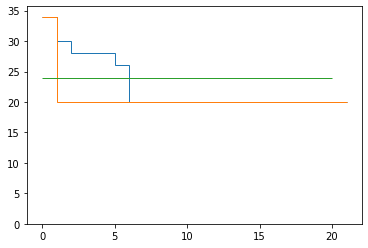

In [89]:
import matplotlib.pyplot as plt
plot1 = plt.stairs(RW, label=f'Random Walk: {RW[-1]}', baseline=None)
plot1 = plt.stairs(HC, label=f'Hill Climbing: {HC[-1]}', baseline=None)
plot1 = plt.stairs(GA, label=f'Genetic Algorithm: {GA[-1]}', baseline=None)
plot1 = plt.stairs(SA, label=f'Simulated Annealing: {SA[-1]}', baseline=None)
plot1 = plt.stairs(TS, label=f'Tabular Search: {TS[-1]}', baseline=None)

plot1 = plt.xlabel('Iterations')
plot1 = plt.ylabel('Travel Distances')
plot1 = plt.title('FE plot')
# plt.xlim()

plot1 = plt.grid(axis='both', color='0.95')

plot1 = plt.legend(loc=3)

plot1 = plt.show()

In [ ]:
print(SA)
print(HC_best_schedule)
print(TS_best_schedule)